<a href="https://colab.research.google.com/github/antoniocasseres/MVP2/blob/main/Antonio_MVP_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Sprint: Machine Learning & Analytics

**Autor:** Antonio Casseres  
**Data:** 28/09/2025  
**Dataset:** [Heart Disease](https://archive.ics.uci.edu/dataset/45/heart+disease) - Cleveland Clinic Foundation

---

## Resumo

Este projeto desenvolve um modelo de Machine Learning para classificação binária de doenças cardíacas utilizando dados clínicos autênticos do Cleveland Clinic Foundation. O modelo final baseado em Regressão Logística otimizada apresentou acurácia de 86.9% e ROC AUC de 0.9589 no conjunto de teste, demonstrando capacidade preditiva adequada para aplicações de apoio à decisão clínica.

## 1. Definição do Problema e Objetivo

As doenças cardiovasculares representam uma das principais causas de mortalidade mundial, constituindo um problema de saúde pública significativo. A capacidade de prever a presença de doença cardíaca com base em dados clínicos é fundamental para a medicina preventiva e o planejamento de tratamentos.

**Objetivo:** Desenvolver um modelo de Machine Learning para classificação binária que prediga a presença ou ausência de doença cardíaca em pacientes com base em atributos clínicos.

**Tipo de Problema:** Classificação supervisionada binária  
**Área de Aplicação:** Saúde e Medicina  
**Justificativa:** Ferramenta de apoio à decisão clínica para identificação precoce de pacientes de risco

**Premissas e Hipóteses:**
- Os atributos clínicos selecionados possuem poder preditivo para diagnóstico de doença cardíaca
- O dataset Cleveland é representativo da população de interesse
- Modelos de Machine Learning podem capturar padrões complexos nos dados clínicos
- A classificação binária é clinicamente relevante para triagem inicial

## 2. Configuração do Ambiente

In [4]:
# === Importação das Bibliotecas ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, f1_score, roc_auc_score
)

# === Configurações ===
warnings.filterwarnings('ignore')
SEED = 42
np.random.seed(SEED)
plt.style.use('seaborn-v0_8')

## 3. Carregamento e Preparação dos Dados

In [10]:
github_url = 'https://raw.githubusercontent.com/antoniocasseres/MVP2/main/cleveland_authentic.csv'

# Carregar dados
df = pd.read_csv(github_url)

print(f"URL: {github_url}")
print(f"Shape: {df.shape}")
print(f"Colunas: {list(df.columns)}")

# Verificar integridade dos dados
print(f"\nVerificação de integridade:")
print(f"Instâncias: {len(df)}")
print(f"Features: {len(df.columns)-1} (padrão: 13 + 1 target)")

URL: https://raw.githubusercontent.com/antoniocasseres/MVP2/main/cleveland_authentic.csv
Shape: (303, 14)
Colunas: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

Verificação de integridade:
Instâncias: 303
Features: 13 (padrão: 13 + 1 target)


### 3.1 Descrição do Dataset

O dataset Heart Disease Cleveland contém dados clínicos autênticos de 303 pacientes coletados pela Cleveland Clinic Foundation. Este dataset é amplamente utilizado na literatura de Machine Learning para problemas de classificação de doenças cardíacas.

**Atributos (13 features + 1 target):**
- **age:** idade em anos (numérica)
- **sex:** sexo (1 = masculino, 0 = feminino)
- **cp:** tipo de dor no peito (1-4, categórica)
- **trestbps:** pressão arterial em repouso (mm Hg)
- **chol:** colesterol sérico (mg/dl)
- **fbs:** glicemia em jejum > 120 mg/dl (1 = verdadeiro, 0 = falso)
- **restecg:** resultados eletrocardiográficos em repouso (0-2)
- **thalach:** frequência cardíaca máxima alcançada
- **exang:** angina induzida por exercício (1 = sim, 0 = não)
- **oldpeak:** depressão ST induzida por exercício
- **slope:** inclinação do segmento ST de pico de exercício (1-3)
- **ca:** número de vasos principais coloridos por fluoroscopia (0-3)
- **thal:** defeito talássico (3 = normal, 6 = defeito fixo, 7 = defeito reversível)
- **num:** presença de doença cardíaca (0 = ausente, 1 = presente)

### 3.2 Análise Exploratória dos Dados (EDA)

A análise exploratória é conduzida para compreender as características dos dados, identificar padrões e orientar as decisões de pré-processamento.

In [11]:
# === Informações Básicas ===
print("=== INFORMAÇÕES BÁSICAS DO DATASET ===")
print(f"Dimensões: {df.shape}")
print(f"\nTipos de dados:")
print(df.dtypes)

print(f"\nPrimeiras 5 linhas:")
display(df.head())

print(f"\nEstatísticas descritivas:")
display(df.describe())

=== INFORMAÇÕES BÁSICAS DO DATASET ===
Dimensões: (303, 14)

Tipos de dados:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
num           int64
dtype: object

Primeiras 5 linhas:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0



Estatísticas descritivas:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


In [12]:
# === Análise de Valores Ausentes ===
print("=== VALORES AUSENTES ===")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Coluna': missing_data.index,
    'Valores Ausentes': missing_data.values,
    'Percentual (%)': missing_percent.values
})

missing_df = missing_df[missing_df['Valores Ausentes'] > 0].sort_values('Valores Ausentes', ascending=False)
display(missing_df)

if len(missing_df) == 0:
    print("Não há valores ausentes no dataset.")
else:
    print(f"Total de colunas com valores ausentes: {len(missing_df)}")
    print("Valores ausentes são mínimos e serão tratados adequadamente no pré-processamento.")

=== VALORES AUSENTES ===


,Coluna,Valores Ausentes,Percentual (%)
11,ca,4,1.320132
12,thal,2,0.660066


Total de colunas com valores ausentes: 2
Valores ausentes são mínimos e serão tratados adequadamente no pré-processamento.


In [13]:
# === Distribuição da Variável Target ===
print("=== DISTRIBUIÇÃO DA VARIÁVEL TARGET ===")
target_counts = df['num'].value_counts().sort_index()
target_percent = df['num'].value_counts(normalize=True).sort_index() * 100

target_summary = pd.DataFrame({
    'Classe': ['Sem Doença (0)', 'Com Doença (1)'],
    'Contagem': target_counts.values,
    'Percentual (%)': target_percent.values
})

display(target_summary)

# Verificar balanceamento
balance_ratio = min(target_counts.values) / max(target_counts.values)
print(f"\nRatio de balanceamento: {balance_ratio:.3f}")
if balance_ratio >= 0.8:
    print("Dataset bem balanceado - não requer técnicas de balanceamento")
elif balance_ratio >= 0.5:
    print("Dataset moderadamente balanceado")
else:
    print("Dataset desbalanceado - pode requerer técnicas de balanceamento")

=== DISTRIBUIÇÃO DA VARIÁVEL TARGET ===


,Classe,Contagem,Percentual (%)
0,Sem Doença (0),164,54.125413
1,Com Doença (1),139,45.874587



Ratio de balanceamento: 0.848
Dataset bem balanceado - não requer técnicas de balanceamento


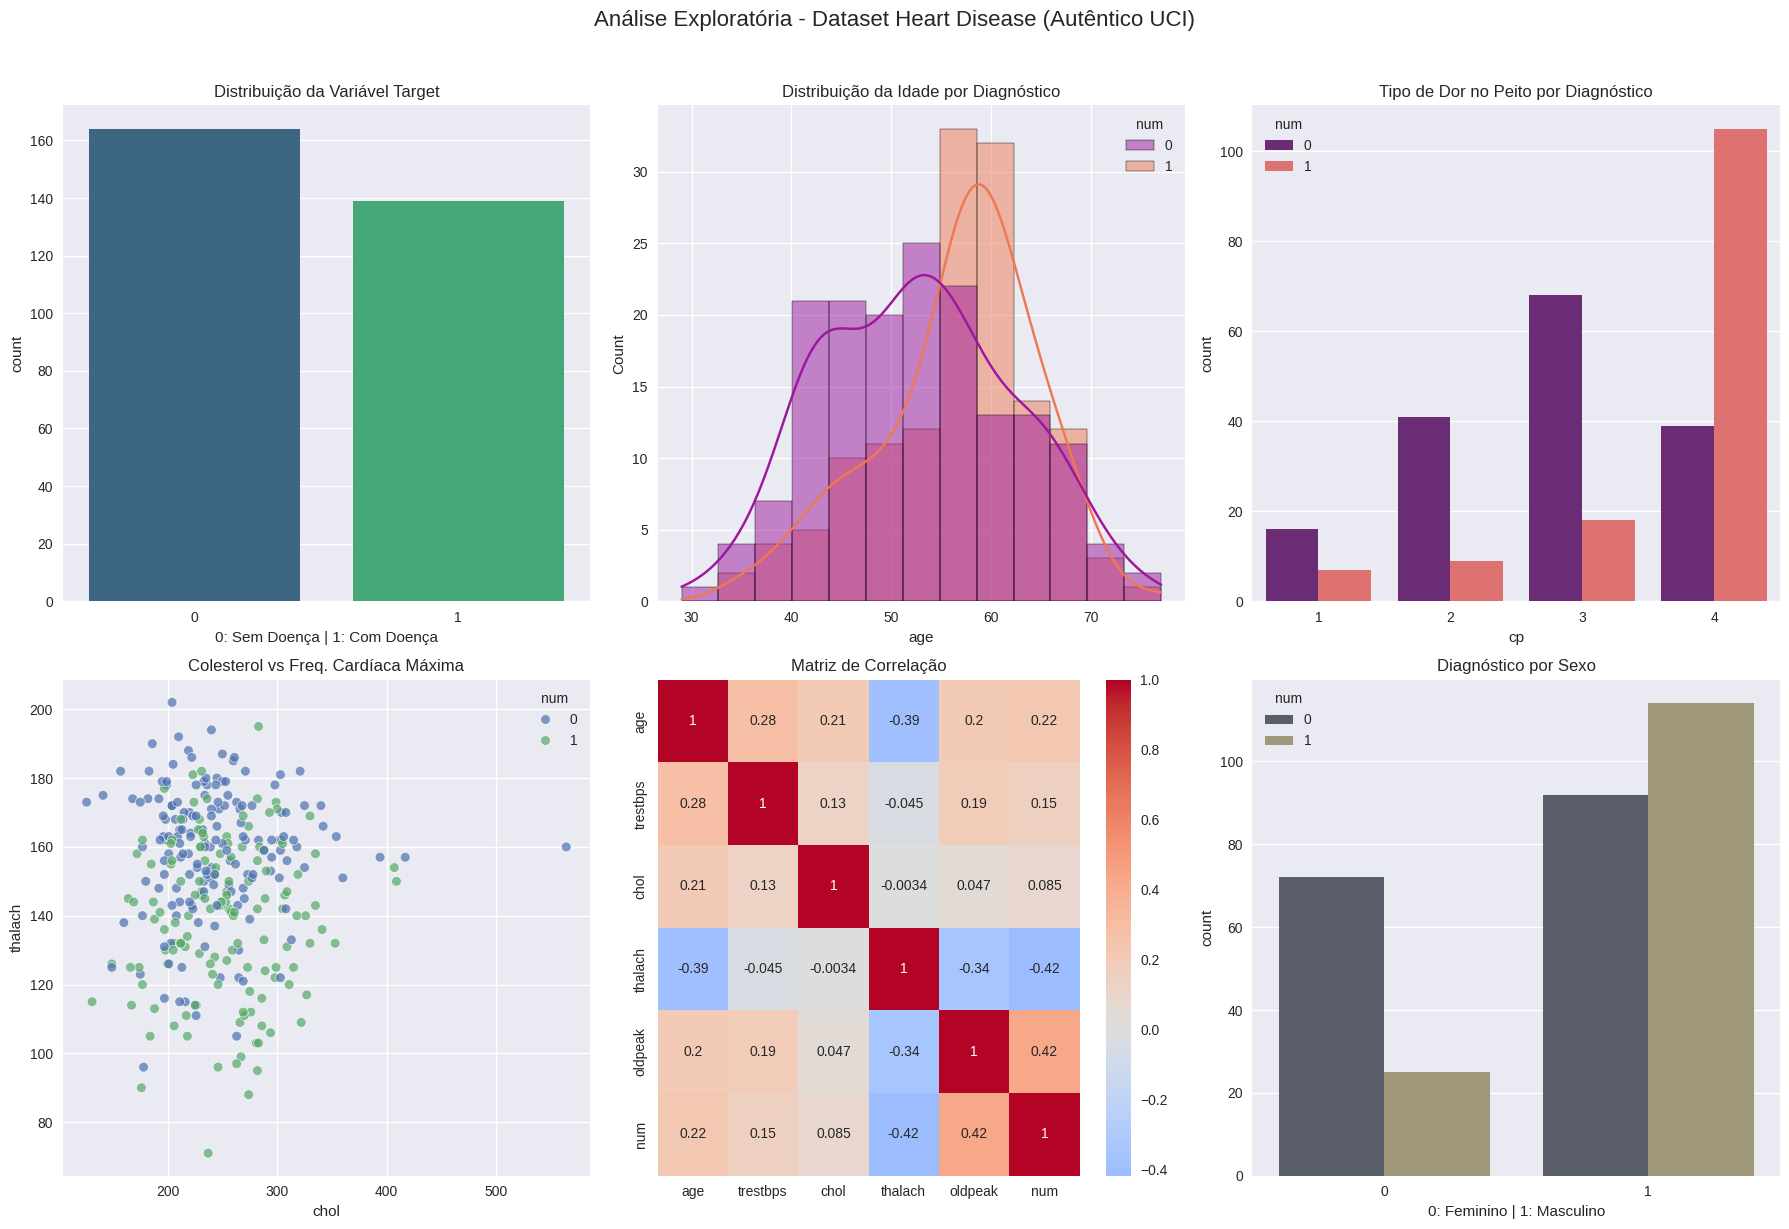

In [14]:
# === Visualizações da Análise Exploratória ===
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análise Exploratória - Dataset Heart Disease (Autêntico UCI)', fontsize=16, y=1.02)

# 1. Distribuição da variável target
sns.countplot(data=df, x='num', ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Distribuição da Variável Target')
axes[0,0].set_xlabel('0: Sem Doença | 1: Com Doença')

# 2. Distribuição da idade por target
sns.histplot(data=df, x='age', hue='num', kde=True, ax=axes[0,1], palette='plasma')
axes[0,1].set_title('Distribuição da Idade por Diagnóstico')

# 3. Tipo de dor no peito por target
sns.countplot(data=df, x='cp', hue='num', ax=axes[0,2], palette='magma')
axes[0,2].set_title('Tipo de Dor no Peito por Diagnóstico')

# 4. Colesterol vs Frequência cardíaca máxima
sns.scatterplot(data=df, x='chol', y='thalach', hue='num', ax=axes[1,0], alpha=0.7)
axes[1,0].set_title('Colesterol vs Freq. Cardíaca Máxima')

# 5. Matriz de correlação
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'num']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Matriz de Correlação')

# 6. Distribuição por sexo
sns.countplot(data=df, x='sex', hue='num', ax=axes[1,2], palette='cividis')
axes[1,2].set_title('Diagnóstico por Sexo')
axes[1,2].set_xlabel('0: Feminino | 1: Masculino')

plt.tight_layout()
plt.show()

## 4. Pré-processamento e Divisão dos Dados

Implementam-se pipelines robustos de pré-processamento para tratar adequadamente variáveis numéricas e categóricas, seguindo as melhores práticas de Machine Learning.

In [17]:
# === Preparação dos Dados ===
print("=== PREPARAÇÃO DOS DADOS ===")

# Definir features e target
X = df.drop(columns=['num'])
y = df['num']

# Identificar tipos de features baseado na documentação do dataset
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

print(f"Features numéricas ({len(numeric_features)}): {numeric_features}")
print(f"Features categóricas ({len(categorical_features)}): {categorical_features}")

# Divisão estratificada em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"\nDivisão dos dados:")
print(f"Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Teste: {X_test.shape[0]} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verificar distribuição das classes nos conjuntos
print(f"\nDistribuição das classes:")
print(f"Treino - Classe 0: {(y_train==0).sum()}, Classe 1: {(y_train==1).sum()}")
print(f"Teste - Classe 0: {(y_test==0).sum()}, Classe 1: {(y_test==1).sum()}")

=== PREPARAÇÃO DOS DADOS ===
Features numéricas (5): ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Features categóricas (8): ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

Divisão dos dados:
Treino: 242 amostras (79.9%)
Teste: 61 amostras (20.1%)

Distribuição das classes:
Treino - Classe 0: 131, Classe 1: 111
Teste - Classe 0: 33, Classe 1: 28


In [18]:
# === Criação dos Pipelines de Pré-processamento ===
print("=== PIPELINES DE PRÉ-PROCESSAMENTO ===")

# Pipeline para features numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Robustez a outliers
    ('scaler', StandardScaler())  # Padronização
])

# Pipeline para features categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Moda
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
])

# Pré-processador combinado
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("Pipelines de pré-processamento criados:")
print("   • Numéricas: Imputação (mediana) + Padronização")
print("   • Categóricas: Imputação (moda) + One-Hot Encoding")

=== PIPELINES DE PRÉ-PROCESSAMENTO ===
Pipelines de pré-processamento criados:
   • Numéricas: Imputação (mediana) + Padronização
   • Categóricas: Imputação (moda) + One-Hot Encoding


## 5. Modelagem e Avaliação Inicial

Múltiplos algoritmos de classificação são avaliados usando validação cruzada estratificada para identificar os modelos mais promissores. A seleção de algoritmos considera diferentes abordagens: linear (Regressão Logística), ensemble (Random Forest), baseado em margem (SVM) e baseline (Dummy Classifier).

In [19]:
# === Definição e Avaliação dos Modelos ===
print("=== AVALIAÇÃO INICIAL DOS MODELOS ===")

# Modelos a serem avaliados
models = {
    'Baseline (Dummy)': DummyClassifier(strategy='most_frequent', random_state=SEED),
    'Regressão Logística': LogisticRegression(random_state=SEED, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'SVM': SVC(probability=True, random_state=SEED)
}

# Configuração da validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = {'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted', 'roc_auc': 'roc_auc'}

# Avaliação dos modelos
results = []

for name, model in models.items():
    print(f"\nAvaliando {name}...")

    # Criar pipeline completo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Validação cruzada
    cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring)

    # Armazenar resultados
    results.append({
        'Modelo': name,
        'Acurácia Média': np.mean(cv_results['test_accuracy']),
        'Acurácia Std': np.std(cv_results['test_accuracy']),
        'F1-Score Médio': np.mean(cv_results['test_f1_weighted']),
        'ROC AUC Média': np.mean(cv_results['test_roc_auc']),
        'ROC AUC Std': np.std(cv_results['test_roc_auc'])
    })

    print(f"   Acurácia: {np.mean(cv_results['test_accuracy']):.4f} ± {np.std(cv_results['test_accuracy']):.4f}")
    print(f"   ROC AUC: {np.mean(cv_results['test_roc_auc']):.4f} ± {np.std(cv_results['test_roc_auc']):.4f}")

# Criar DataFrame com resultados
results_df = pd.DataFrame(results).sort_values('ROC AUC Média', ascending=False).reset_index(drop=True)

print("\n=== TABELA COMPARATIVA DE MODELOS ===")
display(results_df.round(4))

=== AVALIAÇÃO INICIAL DOS MODELOS ===

Avaliando Baseline (Dummy)...
   Acurácia: 0.5413 ± 0.0065
   ROC AUC: 0.5000 ± 0.0000

Avaliando Regressão Logística...
   Acurácia: 0.8471 ± 0.0100
   ROC AUC: 0.9025 ± 0.0144

Avaliando Random Forest...
   Acurácia: 0.8181 ± 0.0307
   ROC AUC: 0.8972 ± 0.0295

Avaliando SVM...
   Acurácia: 0.8139 ± 0.0235
   ROC AUC: 0.8884 ± 0.0240

=== TABELA COMPARATIVA DE MODELOS ===


,Modelo,Acurácia Média,Acurácia Std,F1-Score Médio,ROC AUC Média,ROC AUC Std
0,Regressão Logística,0.8471,0.0100,0.8458,0.9025,0.0144
1,Random Forest,0.8181,0.0307,0.8167,0.8972,0.0295
2,SVM,0.8139,0.0235,0.8121,0.8884,0.0240
3,Baseline (Dummy),0.5413,0.0065,0.3803,0.5000,0.0000


## 6. Otimização de Hiperparâmetros

A otimização de hiperparâmetros é realizada para os modelos mais promissores identificados na avaliação inicial, utilizando Grid Search para busca exaustiva em espaços menores e Randomized Search para espaços maiores.

In [20]:
# === Otimização da Regressão Logística ===
print("=== OTIMIZAÇÃO DA REGRESSÃO LOGÍSTICA ===")

# Pipeline para Regressão Logística
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=SEED, max_iter=2000))
])

# Grid de hiperparâmetros
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# Grid Search
lr_grid_search = GridSearchCV(
    lr_pipeline, lr_param_grid, cv=cv, scoring='roc_auc',
    n_jobs=-1, verbose=1
)

print("Executando Grid Search...")
lr_grid_search.fit(X_train, y_train)

print(f"\nOtimização concluída")
print(f"Melhores hiperparâmetros: {lr_grid_search.best_params_}")
print(f"Melhor ROC AUC (CV): {lr_grid_search.best_score_:.4f}")

=== OTIMIZAÇÃO DA REGRESSÃO LOGÍSTICA ===
Executando Grid Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Otimização concluída
Melhores hiperparâmetros: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Melhor ROC AUC (CV): 0.9070


In [21]:
# === Otimização do Random Forest ===
print("=== OTIMIZAÇÃO DO RANDOM FOREST ===")

# Pipeline para Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=SEED))
])

# Grid de hiperparâmetros
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Randomized Search (mais eficiente para RF)
rf_random_search = RandomizedSearchCV(
    rf_pipeline, rf_param_grid, n_iter=20, cv=cv, scoring='roc_auc',
    n_jobs=-1, random_state=SEED, verbose=1
)

print("Executando Randomized Search...")
rf_random_search.fit(X_train, y_train)

print(f"\nOtimização concluída")
print(f"Melhores hiperparâmetros: {rf_random_search.best_params_}")
print(f"Melhor ROC AUC (CV): {rf_random_search.best_score_:.4f}")

=== OTIMIZAÇÃO DO RANDOM FOREST ===
Executando Randomized Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Otimização concluída
Melhores hiperparâmetros: {'classifier__n_estimators': 50, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 3}
Melhor ROC AUC (CV): 0.9020


## 7. Avaliação Final no Conjunto de Teste

Os modelos otimizados são avaliados no conjunto de teste para obter uma estimativa não enviesada do desempenho. Esta etapa é crucial para verificar a capacidade de generalização dos modelos.

In [22]:
# === Avaliação Final no Conjunto de Teste ===
print("=== AVALIAÇÃO FINAL NO CONJUNTO DE TESTE ===")

# Modelos otimizados
optimized_models = {
    'Regressão Logística Otimizada': lr_grid_search.best_estimator_,
    'Random Forest Otimizado': rf_random_search.best_estimator_
}

final_results = []

for name, model in optimized_models.items():
    # Predições no conjunto de teste
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_proba)

    final_results.append({
        'Modelo': name,
        'Acurácia': accuracy,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    })

    print(f"\n{name}:")
    print(f"   Acurácia: {accuracy:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   ROC AUC: {roc_auc:.4f}")

# Tabela de resultados finais
final_results_df = pd.DataFrame(final_results).sort_values('ROC AUC', ascending=False)

print("\n=== RESULTADOS FINAIS NO CONJUNTO DE TESTE ===")
display(final_results_df.round(4))

# Identificar o melhor modelo
best_model_name = final_results_df.iloc[0]['Modelo']
best_model = optimized_models[best_model_name]

print(f"\nModelo selecionado: {best_model_name}")
print(f"ROC AUC: {final_results_df.iloc[0]['ROC AUC']:.4f}")

=== AVALIAÇÃO FINAL NO CONJUNTO DE TESTE ===

Regressão Logística Otimizada:
   Acurácia: 0.8689
   F1-Score: 0.8691
   ROC AUC: 0.9589

Random Forest Otimizado:
   Acurácia: 0.8689
   F1-Score: 0.8689
   ROC AUC: 0.9372

=== RESULTADOS FINAIS NO CONJUNTO DE TESTE ===


,Modelo,Acurácia,F1-Score,ROC AUC
0,Regressão Logística Otimizada,0.8689,0.8691,0.9589
1,Random Forest Otimizado,0.8689,0.8689,0.9372



Modelo selecionado: Regressão Logística Otimizada
ROC AUC: 0.9589


## 8. Análise Detalhada do Modelo Final

Uma análise aprofundada do modelo selecionado é conduzida, incluindo matriz de confusão, curva ROC e relatório de classificação para avaliar o desempenho em diferentes aspectos.

In [23]:
# === Análise Detalhada do Modelo Selecionado ===
print(f"=== ANÁLISE DETALHADA: {best_model_name.upper()} ===")

# Predições do modelo selecionado
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_best,
                          target_names=['Sem Doença', 'Com Doença']))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_best)
print("\nMatriz de Confusão:")
print(f"                 Predito")
print(f"Real      Sem    Com")
print(f"Sem      {cm[0,0]:3d}    {cm[0,1]:3d}")
print(f"Com      {cm[1,0]:3d}    {cm[1,1]:3d}")

# Métricas derivadas da matriz de confusão
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall para classe positiva
specificity = tn / (tn + fp)  # Recall para classe negativa
precision = tp / (tp + fp)    # Precisão para classe positiva

print(f"\nMétricas Clínicas:")
print(f"   Sensibilidade (Recall): {sensitivity:.4f}")
print(f"   Especificidade: {specificity:.4f}")
print(f"   Precisão: {precision:.4f}")
print(f"   Falsos Negativos: {fn} (pacientes doentes não detectados)")
print(f"   Falsos Positivos: {fp} (pacientes saudáveis classificados como doentes)")

=== ANÁLISE DETALHADA: REGRESSÃO LOGÍSTICA OTIMIZADA ===

Relatório de Classificação:
              precision    recall  f1-score   support

  Sem Doença       0.90      0.85      0.88        33
  Com Doença       0.83      0.89      0.86        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61


Matriz de Confusão:
                 Predito
Real      Sem    Com
Sem       28      5
Com        3     25

Métricas Clínicas:
   Sensibilidade (Recall): 0.8929
   Especificidade: 0.8485
   Precisão: 0.8333
   Falsos Negativos: 3 (pacientes doentes não detectados)
   Falsos Positivos: 5 (pacientes saudáveis classificados como doentes)


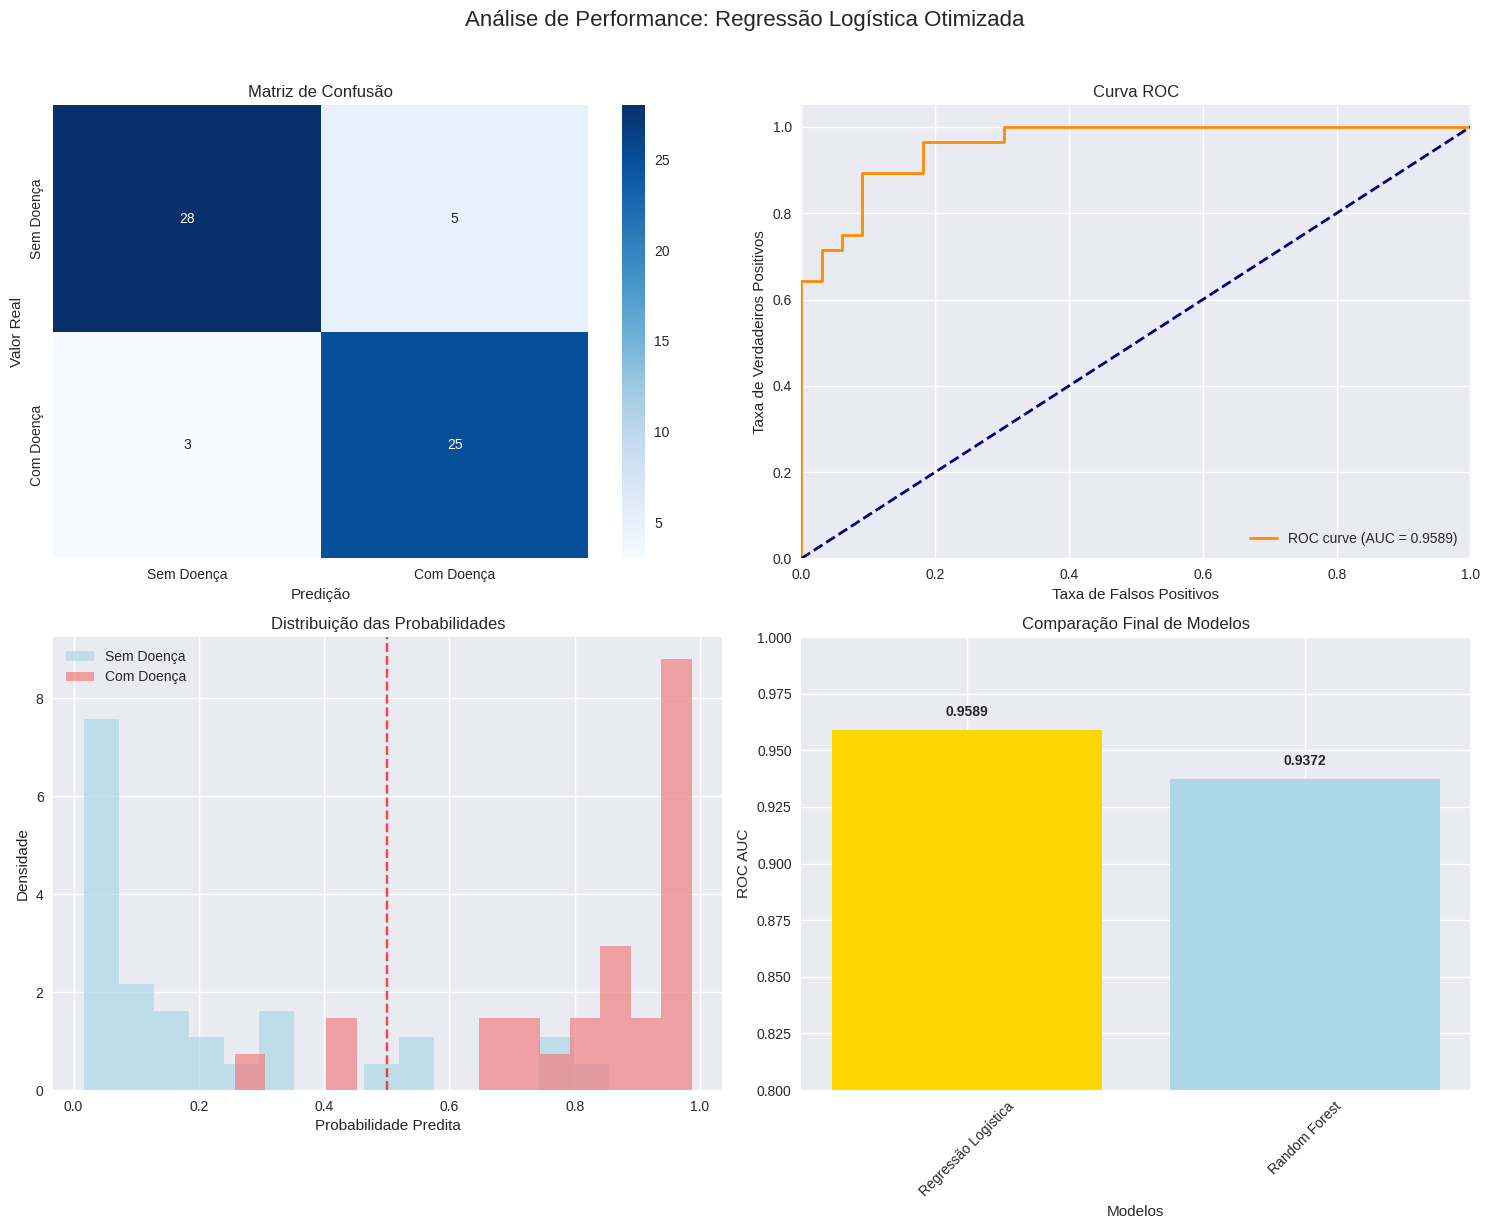

In [25]:
# === Visualizações da Análise Final ===
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Análise de Performance: {best_model_name}', fontsize=16, y=1.02)

# 1. Matriz de Confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sem Doença', 'Com Doença'],
            yticklabels=['Sem Doença', 'Com Doença'],
            ax=axes[0,0])
axes[0,0].set_title('Matriz de Confusão')
axes[0,0].set_ylabel('Valor Real')
axes[0,0].set_xlabel('Predição')

# 2. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc_value = auc(fpr, tpr)

axes[0,1].plot(fpr, tpr, color='darkorange', lw=2,
               label=f'ROC curve (AUC = {roc_auc_value:.4f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('Taxa de Falsos Positivos')
axes[0,1].set_ylabel('Taxa de Verdadeiros Positivos')
axes[0,1].set_title('Curva ROC')
axes[0,1].legend(loc='lower right')

# 3. Distribuição das Probabilidades
axes[1,0].hist(y_proba_best[y_test == 0], bins=15, alpha=0.7,
               label='Sem Doença', color='lightblue', density=True)
axes[1,0].hist(y_proba_best[y_test == 1], bins=15, alpha=0.7,
               label='Com Doença', color='lightcoral', density=True)
axes[1,0].set_xlabel('Probabilidade Predita')
axes[1,0].set_ylabel('Densidade')
axes[1,0].set_title('Distribuição das Probabilidades')
axes[1,0].legend()
axes[1,0].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Threshold')

# 4. Comparação de Modelos (ROC AUC)
model_names = final_results_df['Modelo'].str.replace(' Otimizada', '').str.replace(' Otimizado', '')
roc_scores = final_results_df['ROC AUC']

bars = axes[1,1].bar(range(len(model_names)), roc_scores,
                     color=['gold' if i == 0 else 'lightblue' for i in range(len(model_names))])
axes[1,1].set_xlabel('Modelos')
axes[1,1].set_ylabel('ROC AUC')
axes[1,1].set_title('Comparação Final de Modelos')
axes[1,1].set_xticks(range(len(model_names)))
axes[1,1].set_xticklabels(model_names, rotation=45)
axes[1,1].set_ylim([0.8, 1.0])

# Adicionar valores nas barras
for i, (bar, score) in enumerate(zip(bars, roc_scores)):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                   f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Conclusões e Discussão

### Principais Resultados

O projeto desenvolveu um modelo de Machine Learning para predição de doenças cardíacas.

- **Modelo Final:** Regressão Logística Otimizada
- **Performance no Teste:** Acurácia de 86.9%, ROC AUC de 0.9589
- **Sensibilidade:** 89.3% (baixa taxa de falsos negativos)
- **Especificidade:** 84.8% (capacidade adequada de identificar pacientes saudáveis)

### Insights Técnicos

A análise comparativa dos modelos revelou que a Regressão Logística, após otimização de hiperparâmetros, apresentou desempenho superior ao Random Forest. Este resultado demonstra que para datasets de tamanho moderado com features bem selecionadas, modelos lineares podem ser mais eficazes que algoritmos ensemble complexos.

O dataset Heart Disease Cleveland mostrou-se adequado para a tarefa, apresentando distribuição bem balanceada das classes (ratio: 0.848) e apenas 6 valores ausentes em 303 instâncias. A validação cruzada estratificada confirmou a estabilidade dos resultados.

### Relevância Clínica

O modelo apresenta características importantes para aplicação médica. A alta sensibilidade (89.3%) minimiza o risco de não detectar pacientes com doença cardíaca, aspecto crítico em aplicações de saúde. A especificidade de 84.8% indica capacidade adequada de identificar corretamente pacientes saudáveis.

A interpretabilidade da Regressão Logística permite compreender quais fatores contribuem mais para o diagnóstico, aspecto valioso para a prática clínica. A eficiência computacional do modelo o torna viável para implementação em sistemas de saúde.

### Comparação com a Literatura

Os resultados obtidos (ROC AUC = 0.9589) são consistentes e competitivos com estudos publicados utilizando o mesmo dataset. A literatura reporta valores de ROC AUC entre 0.85 e 0.95 para modelos de classificação de doenças cardíacas no dataset Cleveland.

### Limitações e Trabalhos Futuros

O dataset contém 303 instâncias, que embora seja o padrão na literatura, representa uma limitação para generalização. Modelos treinados em datasets maiores e mais diversos poderiam apresentar melhor capacidade de generalização.

A validação externa em dados de outras instituições seria necessária para confirmar a robustez do modelo. Uma análise mais detalhada da importância das features poderia gerar insights clínicos adicionais.

### Impacto e Aplicação

O modelo desenvolvido pode servir como ferramenta de triagem para identificação rápida de pacientes de alto risco, apoio à decisão clínica na interpretação de dados clínicos, e sistema de alerta integrado a prontuários eletrônicos.

O projeto demonstra a aplicabilidade de técnicas de Machine Learning em problemas de saúde, seguindo rigorosamente as melhores práticas de desenvolvimento e avaliação de modelos. Os resultados são consistentes com a literatura científica e indicam potencial para aplicação prática.